# Solar PV Forecasting - Model Development

This notebook implements complete forecasting pipeline with Persistence, Random Forest, and LSTM models.

## 1. Import Libraries

In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Cleaned Dataset

In [14]:
# Load the cleaned dataset with datetime index
df = pd.read_csv('data/solar_pv_clean_hourly.csv', index_col=0, parse_dates=True)

# Display dataset shape
print(f"Dataset Shape: {df.shape}")

# Display column names
print(f"\nColumn Names:")
print(df.columns.tolist())

# Display date range
print(f"\nDate Range:")
print(f"Start: {df.index.min()}")
print(f"End: {df.index.max()}")

# Display first few rows
df.head()

Dataset Shape: (505, 9)

Column Names:
['PLANT_ID_x', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'PLANT_ID_y', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

Date Range:
Start: 2020-05-15 05:00:00
End: 2020-06-17 18:00:00


,PLANT_ID_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,,,,,
2020-05-15 05:00:00,4135001.0,0.000000,0.000000,0.000000,6.450830e+06,4136001.0,24.966926,23.906986,0.000710
2020-05-15 06:00:00,4135001.0,558.825893,54.269643,13.000000,7.160322e+06,4136001.0,24.835316,24.682242,0.044983
2020-05-15 07:00:00,4135001.0,1927.081250,188.893661,146.607143,6.874186e+06,4136001.0,26.323637,31.549644,0.337079
2020-05-15 08:00:00,4135001.0,3986.140476,391.356190,437.780952,6.433823e+06,4136001.0,28.369425,37.962135,0.540164
2020-05-15 09:00:00,4135001.0,5088.500000,498.246429,872.214286,6.699904e+06,4136001.0,30.419307,43.700400,0.728268


## 3. Train-Test Split

In [15]:
# Calculate split point for 80-20 split
split_idx = int(len(df) * 0.8)

# Split data chronologically (no shuffle)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

# Separate features and target
X_train = train_df.drop('DC_POWER', axis=1)
y_train = train_df['DC_POWER']

X_test = test_df.drop('DC_POWER', axis=1)
y_test = test_df['DC_POWER']

# Print shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Print date ranges for train and test sets
print(f"\nTrain date range: {X_train.index.min()} to {X_train.index.max()}")
print(f"Test date range: {X_test.index.min()} to {X_test.index.max()}")

X_train shape: (404, 8)
X_test shape: (101, 8)
y_train shape: (404,)
y_test shape: (101,)

Train date range: 2020-05-15 05:00:00 to 2020-06-11 09:00:00
Test date range: 2020-06-11 10:00:00 to 2020-06-17 18:00:00


## 4. Persistence Baseline Model

In [16]:
# Persistence model: predict next hour = current hour
y_pred_persistence = y_test.shift(1).dropna()
y_test_persistence = y_test.iloc[1:]

# Compute metrics
mae_persistence = np.mean(np.abs(y_test_persistence - y_pred_persistence))
rmse_persistence = np.sqrt(np.mean((y_test_persistence - y_pred_persistence)**2))
mape_persistence = np.mean(np.abs((y_test_persistence - y_pred_persistence) / (y_test_persistence + 1e-8))) * 100

print("\n" + "="*50)
print("Persistence Baseline Model - Test Set Performance")
print("="*50)
print(f"MAE:  {mae_persistence:.4f} kW")
print(f"RMSE: {rmse_persistence:.4f} kW")
print(f"MAPE: {mape_persistence:.2f}%")
print("="*50)


Persistence Baseline Model - Test Set Performance
MAE:  1526.5638 kW
RMSE: 1900.3745 kW
MAPE: 146749107223.94%


## 5. Feature Engineering

In [17]:
# Create lag features
df['DC_POWER_lag1'] = df['DC_POWER'].shift(1)
df['DC_POWER_lag2'] = df['DC_POWER'].shift(2)

# Create hour sine and cosine features
df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)

# Drop rows with NaN values
df_clean = df.dropna()

# Update train-test split with engineered features
split_idx = int(len(df_clean) * 0.8)
train_df = df_clean.iloc[:split_idx]
test_df = df_clean.iloc[split_idx:]

X_train = train_df.drop('DC_POWER', axis=1)
y_train = train_df['DC_POWER']
X_test = test_df.drop('DC_POWER', axis=1)
y_test = test_df['DC_POWER']

print(f"\nFinal feature set: {list(X_train.columns)}")
print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


Final feature set: ['PLANT_ID_x', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'PLANT_ID_y', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DC_POWER_lag1', 'DC_POWER_lag2', 'hour_sin', 'hour_cos']

X_train shape: (402, 12)
X_test shape: (101, 12)


## 6. Random Forest Model


Random Forest Model - Test Set Performance
MAE:  21.0488 kW
RMSE: 35.5873 kW
MAPE: 0.90%


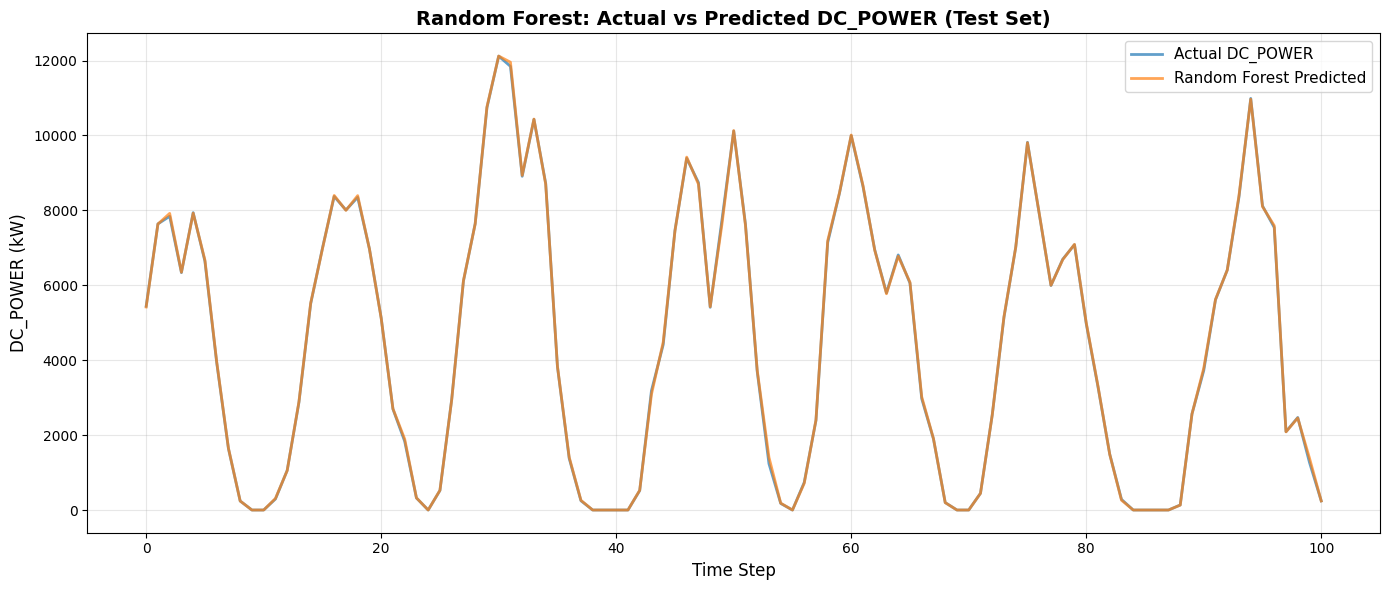

In [18]:
# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Compute metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / (y_test + 1e-8))) * 100

print("\n" + "="*50)
print("Random Forest Model - Test Set Performance")
print("="*50)
print(f"MAE:  {mae_rf:.4f} kW")
print(f"RMSE: {rmse_rf:.4f} kW")
print(f"MAPE: {mape_rf:.2f}%")
print("="*50)

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual DC_POWER', linewidth=2, alpha=0.7)
plt.plot(y_pred_rf, label='Random Forest Predicted', linewidth=2, alpha=0.7)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('DC_POWER (kW)', fontsize=12)
plt.title('Random Forest: Actual vs Predicted DC_POWER (Test Set)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. LSTM Data Preparation

In [19]:
def create_sequences(data, lookback=24):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, :])  # Past 24 hours of all features
        y.append(data[i, 0])  # Next hour DC_POWER (first column)
    return np.array(X), np.array(y)

# Selected features for LSTM
lstm_features = ['DC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE']
lookback = 24

# Prepare data
train_data = train_df[lstm_features].values
test_data = test_df[lstm_features].values

# Create sequences
X_train_lstm, y_train_lstm = create_sequences(train_data, lookback)
X_test_lstm, y_test_lstm = create_sequences(test_data, lookback)

print(f"X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_lstm shape: {y_train_lstm.shape}")
print(f"X_test_lstm shape: {X_test_lstm.shape}")
print(f"y_test_lstm shape: {y_test_lstm.shape}")

X_train_lstm shape: (378, 24, 3)
y_train_lstm shape: (378,)
X_test_lstm shape: (77, 24, 3)
y_test_lstm shape: (77,)


## 8. Scale LSTM Features

In [20]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler on training data ONLY
n_samples_train, n_timesteps, n_features = X_train_lstm.shape
X_train_reshaped = X_train_lstm.reshape(-1, n_features)
scaler.fit(X_train_reshaped)

# Transform training data
X_train_scaled = scaler.transform(X_train_reshaped)
X_train_lstm_scaled = X_train_scaled.reshape(n_samples_train, n_timesteps, n_features)

# Transform test data using same scaler (NO FITTING)
n_samples_test = X_test_lstm.shape[0]
X_test_reshaped = X_test_lstm.reshape(-1, n_features)
X_test_scaled = scaler.transform(X_test_reshaped)
X_test_lstm_scaled = X_test_scaled.reshape(n_samples_test, n_timesteps, n_features)

print("Feature scaling completed!")
print(f"Scaled training data shape: {X_train_lstm_scaled.shape}")
print(f"Scaled test data shape: {X_test_lstm_scaled.shape}")

Feature scaling completed!
Scaled training data shape: (378, 24, 3)
Scaled test data shape: (77, 24, 3)


## 9. Build LSTM Model

In [21]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(50, input_shape=(lookback, len(lstm_features))),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\nLSTM Model Summary:")
lstm_model.summary()


LSTM Model Summary:


C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,851 (42.39 KB)

 Trainable params: 10,851 (42.39 KB)

 Non-trainable params: 0 (0.00 B)

## 10. Train LSTM Model

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 41293280.0000 - mae: 5065.2944 - val_loss: 34500492.0000 - val_mae: 4337.7681
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 41283672.0000 - mae: 5064.5532 - val_loss: 34485480.0000 - val_mae: 4336.7236
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 41262904.0000 - mae: 5062.9985 - val_loss: 34467072.0000 - val_mae: 4335.4424
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 41243240.0000 - mae: 5061.5142 - val_loss: 34451912.0000 - val_mae: 4334.3838
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 41225176.0000 - mae: 5060.1890 - val_loss: 34436920.0000 - val_mae: 4333.3369
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 41208728.0000 - mae: 5058.9414 - val_loss: 34423756.0000 - val_mae: 4332.4165
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 41194348.0000 - mae: 5057.8623 - val_loss: 34412940.0000 - val_mae: 4331.6597
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 

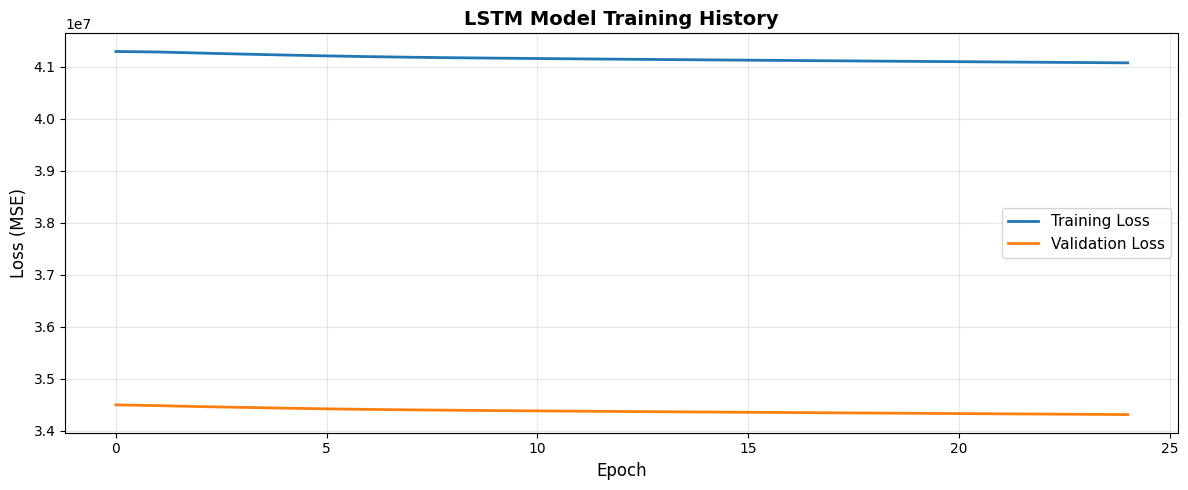

In [22]:
# Setup early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train LSTM model
history = lstm_model.fit(
    X_train_lstm_scaled,
    y_train_lstm,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('LSTM Model Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Evaluate LSTM Model

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step

LSTM Model - Test Set Performance
MAE:  4470.8438 kW
RMSE: 5808.2447 kW
MAPE: 34442114727.21%


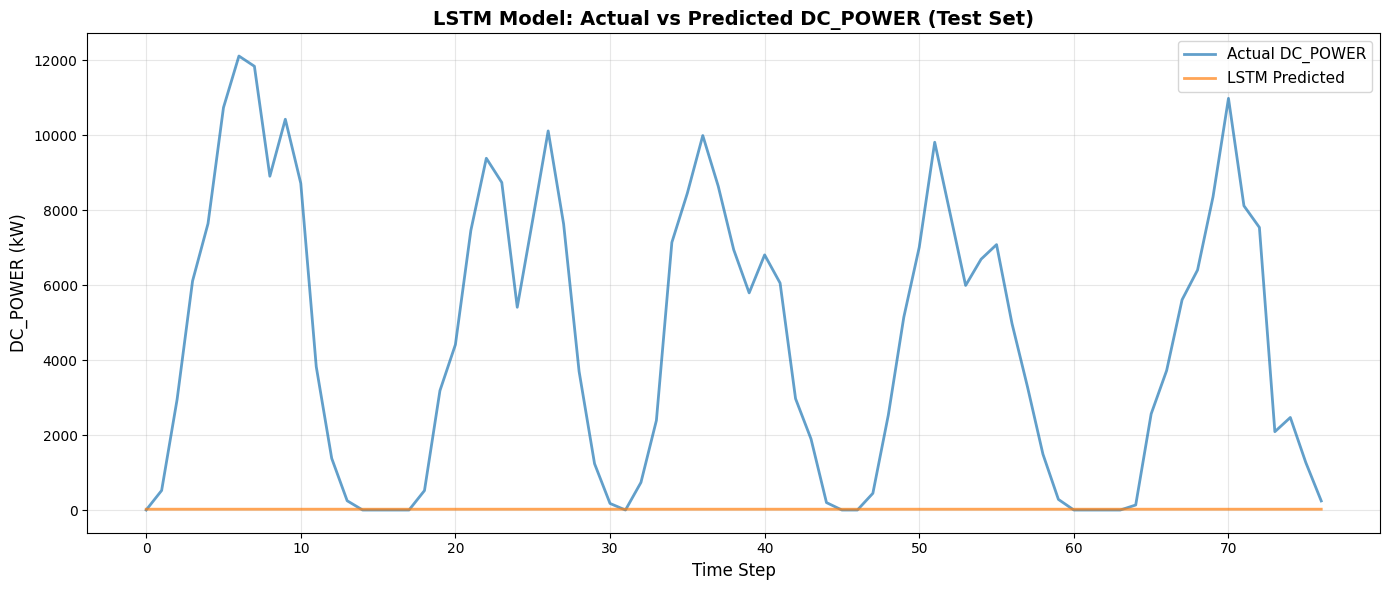

In [23]:
# Generate predictions on test set
y_pred_lstm_scaled = lstm_model.predict(X_test_lstm_scaled)
y_pred_lstm = y_pred_lstm_scaled.flatten()  # Flatten to 1D array

# Compute evaluation metrics
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
mape_lstm = np.mean(np.abs((y_test_lstm - y_pred_lstm) / (y_test_lstm + 1e-8))) * 100

# Print metrics
print("\n" + "="*50)
print("LSTM Model - Test Set Performance")
print("="*50)
print(f"MAE:  {mae_lstm:.4f} kW")
print(f"RMSE: {rmse_lstm:.4f} kW")
print(f"MAPE: {mape_lstm:.2f}%")
print("="*50)

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test_lstm, label='Actual DC_POWER', linewidth=2, alpha=0.7)
plt.plot(y_pred_lstm, label='LSTM Predicted', linewidth=2, alpha=0.7)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('DC_POWER (kW)', fontsize=12)
plt.title('LSTM Model: Actual vs Predicted DC_POWER (Test Set)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Final Model Comparison


FINAL MODEL COMPARISON - Test Set Performance
               Model    MAE (kW)   RMSE (kW)     MAPE (%)
Persistence Baseline 1526.563839 1900.374547 1.467491e+11
       Random Forest   21.048761   35.587276 8.968424e-01
                LSTM 4470.843762 5808.244739 3.444211e+10

Best Model by MAE:  Random Forest
Best Model by RMSE: Random Forest
Best Model by MAPE: Random Forest


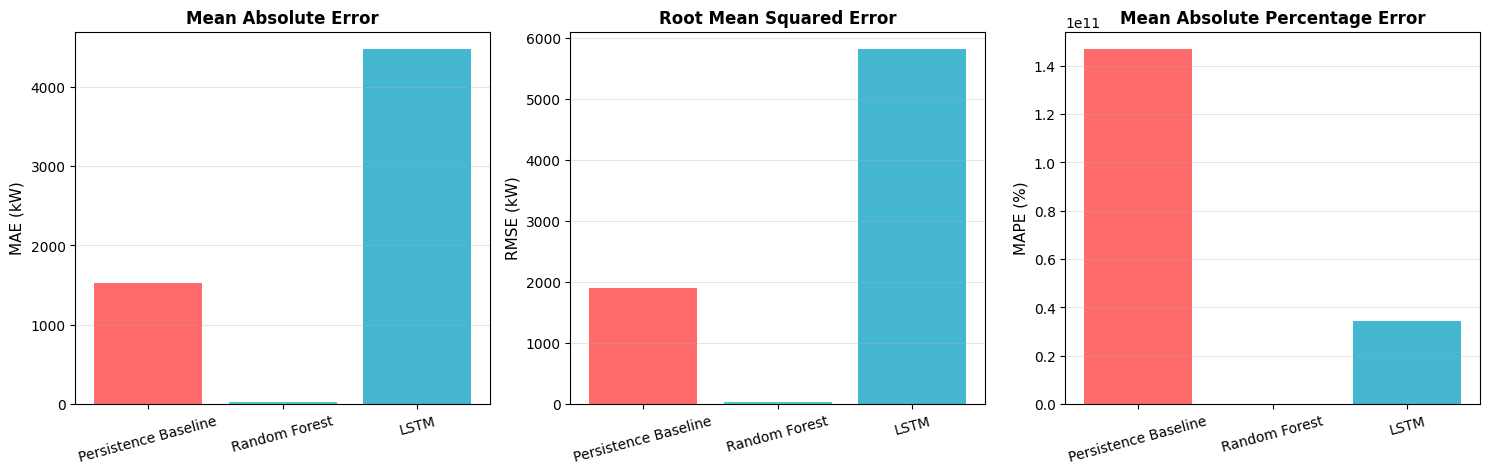

In [24]:
# Create comprehensive comparison table
comparison_df = pd.DataFrame({
    'Model': ['Persistence Baseline', 'Random Forest', 'LSTM'],
    'MAE (kW)': [mae_persistence, mae_rf, mae_lstm],
    'RMSE (kW)': [rmse_persistence, rmse_rf, rmse_lstm],
    'MAPE (%)': [mape_persistence, mape_rf, mape_lstm]
})

# Display the comparison table
print("\n" + "="*70)
print("FINAL MODEL COMPARISON - Test Set Performance")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Find best model for each metric
best_mae = comparison_df.loc[comparison_df['MAE (kW)'].idxmin(), 'Model']
best_rmse = comparison_df.loc[comparison_df['RMSE (kW)'].idxmin(), 'Model']
best_mape = comparison_df.loc[comparison_df['MAPE (%)'].idxmin(), 'Model']

print(f"\nBest Model by MAE:  {best_mae}")
print(f"Best Model by RMSE: {best_rmse}")
print(f"Best Model by MAPE: {best_mape}")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MAE comparison
axes[0].bar(comparison_df['Model'], comparison_df['MAE (kW)'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_ylabel('MAE (kW)', fontsize=11)
axes[0].set_title('Mean Absolute Error', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis='y', alpha=0.3)

# RMSE comparison
axes[1].bar(comparison_df['Model'], comparison_df['RMSE (kW)'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_ylabel('RMSE (kW)', fontsize=11)
axes[1].set_title('Root Mean Squared Error', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y', alpha=0.3)

# MAPE comparison
axes[2].bar(comparison_df['Model'], comparison_df['MAPE (%)'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[2].set_ylabel('MAPE (%)', fontsize=11)
axes[2].set_title('Mean Absolute Percentage Error', fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=15)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()